# Computing Krill NASC from the Pacific Hake Survey

Jupyter notebook accompanying the manuscript:

_Echopype: A Python library for interoperable and scalable processing of ocean sonar data for biological information_   
_Authors: Wu-Jung Lee, Emilio Mayorga, Landung Setiawan, Kavin Nguyen, Imran Majeed, Valentina Staneva, Caesar Tuguinay_

## Introduction

### Description

This notebook uses a subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration, regridding, and frequency differencing using [`echopype`](https://echopype.readthedocs.io) and core scientific Python software packages (particularly `xarray`, `Dask` and `NumPy`) to compute Krill attributed Nautical Areal Scattering Coefficient (NASC).

### Outline

1) Convert EK60 RAW Files to Echodata Objects
2) Combine Echodata Objects
3) Calibrate Combined Echodata Object
4) Regrid Calibrated Data
5) Remove Empty Water from Regridded Calibrated Data
6) Generate Frequency Difference Mask and Apply Mask on Non-Empty Water Regridded Calibrated Data
7) Compute Water Column Krill NASC and dB NASC
8) Plot Water Column Krill dB NASC on map

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/binder/environment.yml. The notebook creates a directory, if not already present: `./exports/krill_notebook_outputs`. Zarr files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency.

In [78]:
from pathlib import Path
import os

import fsspec
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # noqa

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

### Establish AWS S3 file system connection and generate list of target EK60 `.raw` files

Access and inspect the publicly accessible NCEI WCSD S3 bucket on the AWS cloud as if it were a local file system. This will be done through the Python [fsspec](https://filesystem-spec.readthedocs.io) file system and bytes storage interface. We will use `fsspec.filesystem.glob` (`fs.glob`) to generate a list of all EK60 `.raw` data files in the bucket, then filter on file names for target dates of interest. 

The directory path on the [ncei-wcsd-archive S3 bucket](https://ncei-wcsd-archive.s3.amazonaws.com/index.html) is `s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/`. All `.raw` files from the 2017 Hake survey cruise are found here.

In [63]:
# Setup filesystem
fs = fsspec.filesystem('s3', anon=True)
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

# Select the first 5 files from 2017 Hake Survey Cruise
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")
select_files = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728', '0729']])
]
print(f"There are {len(select_files)} target raw files available")

There are 170 target raw files available


Create directories to store Zarr files:

In [ ]:
base_dpath = Path('./exports/krill_notebook_outputs')
base_dpath.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = Path(base_dpath / 'hake_survey_echodata_zarr')
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = Path(base_dpath / 'combined_zarr')
combined_zarr_path.mkdir(exist_ok=True)

### Dask Client Setup

Echopype uses Dask in the background to lazily load, do out-of-memory and parallelized computation on large arrays. Dask Client helps schedule tasks and allocate memory for these large array computations.

In [4]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


The following Echopype processing code follows a pattern of `to_zarr` and "open zarr" for the more computationally challenging processing stages. This patterns points computation outputs to be stored in disk instead of in memory, and when this computation is done, it lazily-loads the recently computed arrays.

### Convert EK60 RAW Files to Echodata Objects

In [68]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in select_files:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 30 s, sys: 4.26 s, total: 34.3 s
Wall time: 1min 9s


### Combine Echodata Objects

In [69]:
%%time

# Open Zarr Stores containing Echodata Objects, Lazy Load them, and Lazily Combine Echodata Objects
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save to Zarr and offload computation to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazily Open Zarr
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/dataset.py:2548: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


CPU times: user 3min 49s, sys: 20.5 s, total: 4min 9s
Wall time: 4min 58s


### Calibrate Combined Echodata Object

Compute Volume Backscattering Strength (Sv), remove background noise, and add depth and latitude/longitude to this Xarray Dataset.

In [70]:
%%time

# Chunk Echodata Object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 24.7 s, sys: 3.65 s, total: 28.3 s
Wall time: 41.9 s


### Regrid Calibrated Data

Compute Mean Volume Backscattering Strength (MVBS)

In [71]:
%%time
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='5m',  # in meters
    ping_time_bin='20s',  # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 31.2 s, sys: 3.78 s, total: 34.9 s
Wall time: 1min 10s


### Remove Empty Water from Regridded Calibrated Data

In [72]:
# Create copy of MVBS
ds_non_empty_MVBS = ds_MVBS.copy()

# Replace all Sv less -70 dB with NaN
ds_non_empty_MVBS["Sv"] = xr.where(ds_MVBS["Sv"] < -70, np.nan, ds_MVBS["Sv"])

### Generate Frequency Difference Mask and Apply Mask on Non-Empty Water Regridded Calibrated Data

Compute Frequency Differencing 16.2dB >= 120kHz - 38kHz >= 10.0dB to identify Krill.

In [73]:
# Compute compute both frequency differencing inequalities as separate masks
freq_diff_mask_1 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz < 16.2dB"
)
freq_diff_mask_2 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz > 10.0dB"
)

# Apply both frequency differencing masks
ds_freq_diff_MVBS = ep.mask.apply_mask(
    ds_non_empty_MVBS,
    [freq_diff_mask_1, freq_diff_mask_2]
)

### Compute Water Column Krill NASC and dB NASC

Compute NASC with a distance bin of 0.5nmi and on the entire water column on the first 250m of the MVBS dataset.

In [74]:
# Compute NASC
ds_freq_diff_NASC = ep.commongrid.compute_NASC(
    # Grab only the first 250m in the MVBS
    ds_freq_diff_MVBS.sel(depth=slice(0, 250)),
    range_bin="250m",
    dist_bin="0.5nmi"
)

# Drop depth from NASC since it is just 1 entry
ds_freq_diff_NASC = ds_freq_diff_NASC.isel(
    depth=0
).drop_vars("depth")

# Compute decibel NASC using elementwise operations and add long name attribute
ds_freq_diff_NASC["dB_NASC"] = 10 * np.log10(ds_freq_diff_NASC["NASC"])
ds_freq_diff_NASC["dB_NASC"].attrs = {
    "long_name": "Decibel Nautical Areal Scattering Coefficient (dB-NASC)",
    "units": "dB m2 nmi-2"
}

# Select the 120 kHz channel
ds_freq_diff_120kHz_NASC = ds_freq_diff_NASC.sel(
    channel="GPT 120 kHz 00907205a6d0 4-1 ES120-7C"
).drop("channel")

### Plot Water Column Krill dB NASC on map

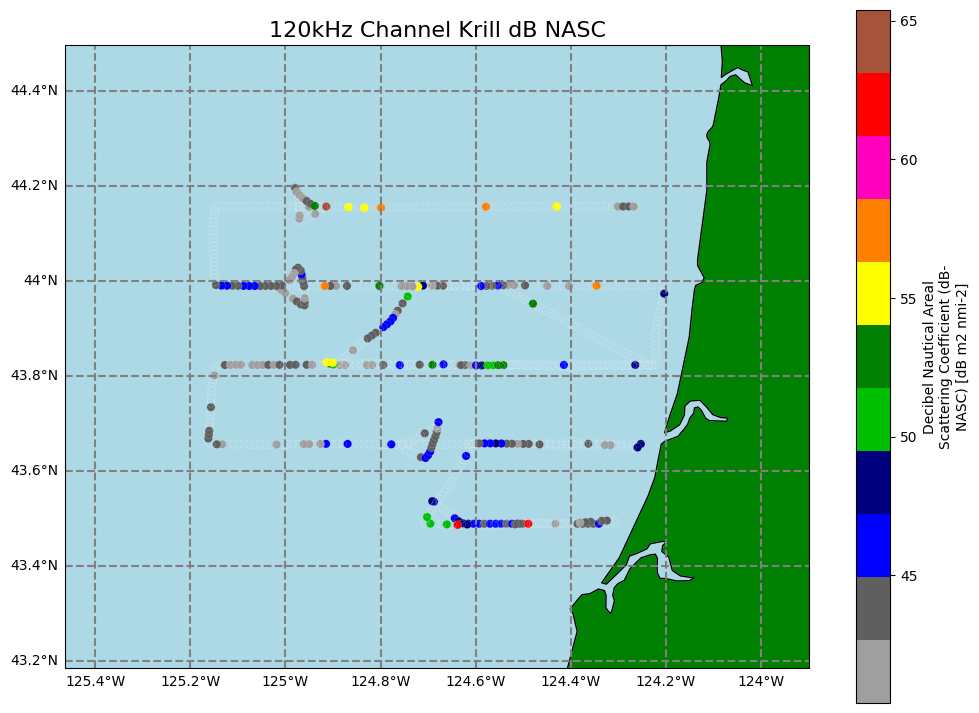

In [79]:
# Create plot
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1.5,
    color='gray',
    linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

# Set lat lon extent
ax.set_extent([
    ds_freq_diff_120kHz_NASC["longitude"].min().values - 0.3,
    ds_freq_diff_120kHz_NASC["longitude"].max().values + 0.3,
    ds_freq_diff_120kHz_NASC["latitude"].min().values - 0.3,
    ds_freq_diff_120kHz_NASC["latitude"].max().values + 0.3,
], crs=ccrs.PlateCarree())

# Add land and ocean features
ax.add_feature(cfeature.LAND, color='green')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Plot dB NASC on map
p = ds_freq_diff_120kHz_NASC.plot.scatter(
    x="longitude",
    y="latitude",
    hue="dB_NASC",
    ax=ax,
    transform=ccrs.PlateCarree(),
    linewidths=0.1,
    cmap="ep.ek500"
)

# Set axes title
p.axes.set_title("120kHz Channel Krill dB NASC", fontsize=16)

# Show plot
plt.show()